# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory


import matplotlib.pyplot as plt

# Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pic_folder = '/content/drive/MyDrive/Final Project/pics'

In [ ]:
import pathlib
data_dir = pathlib.Path(pic_folder)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2840


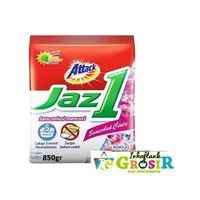

In [ ]:
attackdet = list(data_dir.glob('deterjenattackjpg/*'))
PIL.Image.open(str(attackdet[0]))

In [ ]:
len(attackdet)

710

# Defining the train and validation dataset

In [ ]:
IMG_WIDTH=200
IMG_HEIGHT=200
batch_size=4

In [ ]:
train_dataset = image_dataset_from_directory(
    pic_folder,
    shuffle=True,
    batch_size=batch_size,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    seed  = 42,
    validation_split=0.2,
    subset = "training"
    )

Found 2848 files belonging to 4 classes.
Using 2279 files for training.


In [ ]:
val_dataset = image_dataset_from_directory(
    pic_folder,
    shuffle=True,
    batch_size=batch_size,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    seed  = 42,
    validation_split=0.2,
    subset = "validation"
    )

Found 2848 files belonging to 4 classes.
Using 569 files for validation.


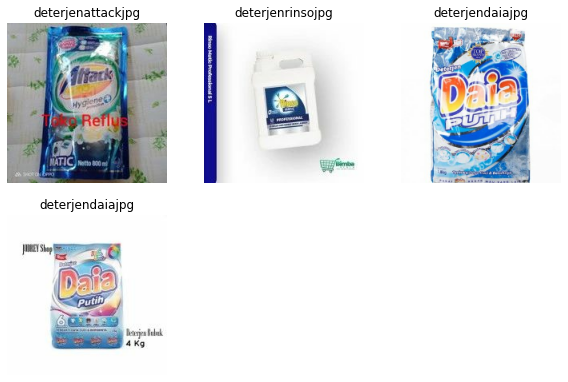

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(4):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Data preprocessing

## Autotune to make the running more efficient

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

## Normalization

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_dataset))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

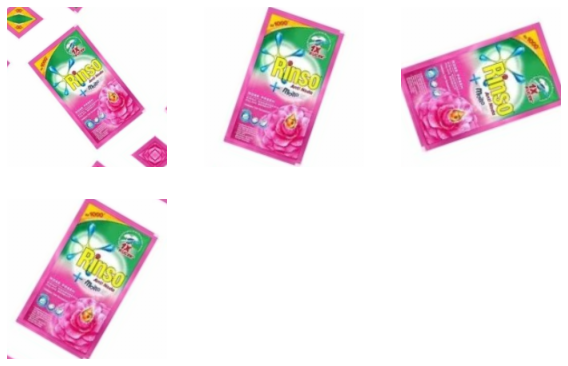

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(4):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Modeling

## first model: VGG16

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model_vgg16 = tf.keras.applications.VGG16(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3), weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = model_vgg16(image_batch)
print(feature_batch.shape)

model_vgg16.trainable = False

model_vgg16.summary()

(4, 6, 6, 512)
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 12

In [ ]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = data_augmentation(inputs)
x = model_vgg16(x, training=False)
x = tf.keras.layers.Dropout(0.3)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(4)(x)
final_vgg16 = tf.keras.Model(inputs, outputs)

In [ ]:
final_vgg16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=20

history = final_vgg16.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs=epochs
)

Epoch 1/20
570/570 [==============================] - 721s 1s/step - loss: 4.2620 - accuracy: 0.6402 - val_loss: 1.0945 - val_accuracy: 0.8137
Epoch 2/20
570/570 [==============================] - 69s 120ms/step - loss: 1.1449 - accuracy: 0.7718 - val_loss: 0.7940 - val_accuracy: 0.8436
Epoch 3/20
570/570 [==============================] - 68s 120ms/step - loss: 0.6557 - accuracy: 0.8262 - val_loss: 0.5612 - val_accuracy: 0.8541
Epoch 4/20
570/570 [==============================] - 69s 120ms/step - loss: 0.4947 - accuracy: 0.8425 - val_loss: 0.4596 - val_accuracy: 0.8946
Epoch 5/20
570/570 [==============================] - 68s 120ms/step - loss: 0.4582 - accuracy: 0.8605 - val_loss: 0.4622 - val_accuracy: 0.8893
Epoch 6/20
570/570 [==============================] - 68s 120ms/step - loss: 0.4119 - accuracy: 0.8780 - val_loss: 0.3747 - val_accuracy: 0.9086
Epoch 7/20
570/570 [==============================] - 68s 120ms/step - loss: 0.3413 - accuracy: 0.9026 - val_loss: 0.3580 - val_accu

In [ ]:
model_vgg16.save('/content/drive/MyDrive/Final Project/model_vgg16_final.h5')

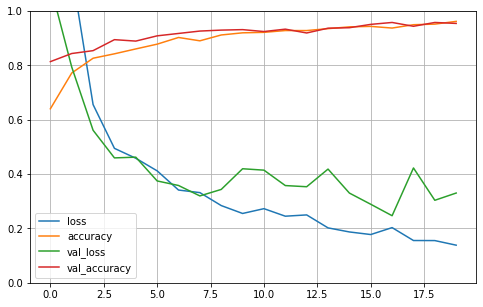

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
# save_fig("keras_learning_curves_plot")
plt.show()

## second model: ResNet50

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model_resnet = tf.keras.applications.ResNet50(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3), weights='imagenet', include_top=False)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = model_resnet(image_batch)
print(feature_batch.shape)

model_resnet.trainable = False

model_resnet.summary()

(4, 7, 7, 2048)
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________

In [ ]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = data_augmentation(inputs)
x = model_resnet(x, training=False)
x = tf.keras.layers.Dropout(0.3)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(4)(x)
final_resnet = tf.keras.Model(inputs, outputs)

In [ ]:
final_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=20

history = final_resnet.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs=epochs
)

Epoch 1/20
570/570 [==============================] - 45s 72ms/step - loss: 0.7524 - accuracy: 0.7771 - val_loss: 0.3606 - val_accuracy: 0.9069
Epoch 2/20
570/570 [==============================] - 39s 69ms/step - loss: 0.3305 - accuracy: 0.8986 - val_loss: 0.2792 - val_accuracy: 0.9227
Epoch 3/20
570/570 [==============================] - 39s 68ms/step - loss: 0.2536 - accuracy: 0.9158 - val_loss: 0.2649 - val_accuracy: 0.9297
Epoch 4/20
570/570 [==============================] - 39s 69ms/step - loss: 0.2595 - accuracy: 0.9241 - val_loss: 0.2471 - val_accuracy: 0.9315
Epoch 5/20
570/570 [==============================] - 39s 69ms/step - loss: 0.1889 - accuracy: 0.9412 - val_loss: 0.3137 - val_accuracy: 0.9192
Epoch 6/20
570/570 [==============================] - 39s 68ms/step - loss: 0.1453 - accuracy: 0.9566 - val_loss: 0.2130 - val_accuracy: 0.9385
Epoch 7/20
570/570 [==============================] - 39s 69ms/step - loss: 0.1694 - accuracy: 0.9539 - val_loss: 0.2259 - val_accuracy:

In [ ]:
model_resnet.save('/content/drive/MyDrive/Final Project/model_resnet_final.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


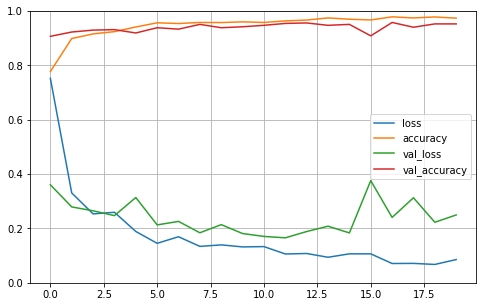

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
# save_fig("keras_learning_curves_plot")
plt.show()

# Model Inference

In [ ]:
test_image = '/content/drive/MyDrive/Final Project/inference/gambar 3.jpg'

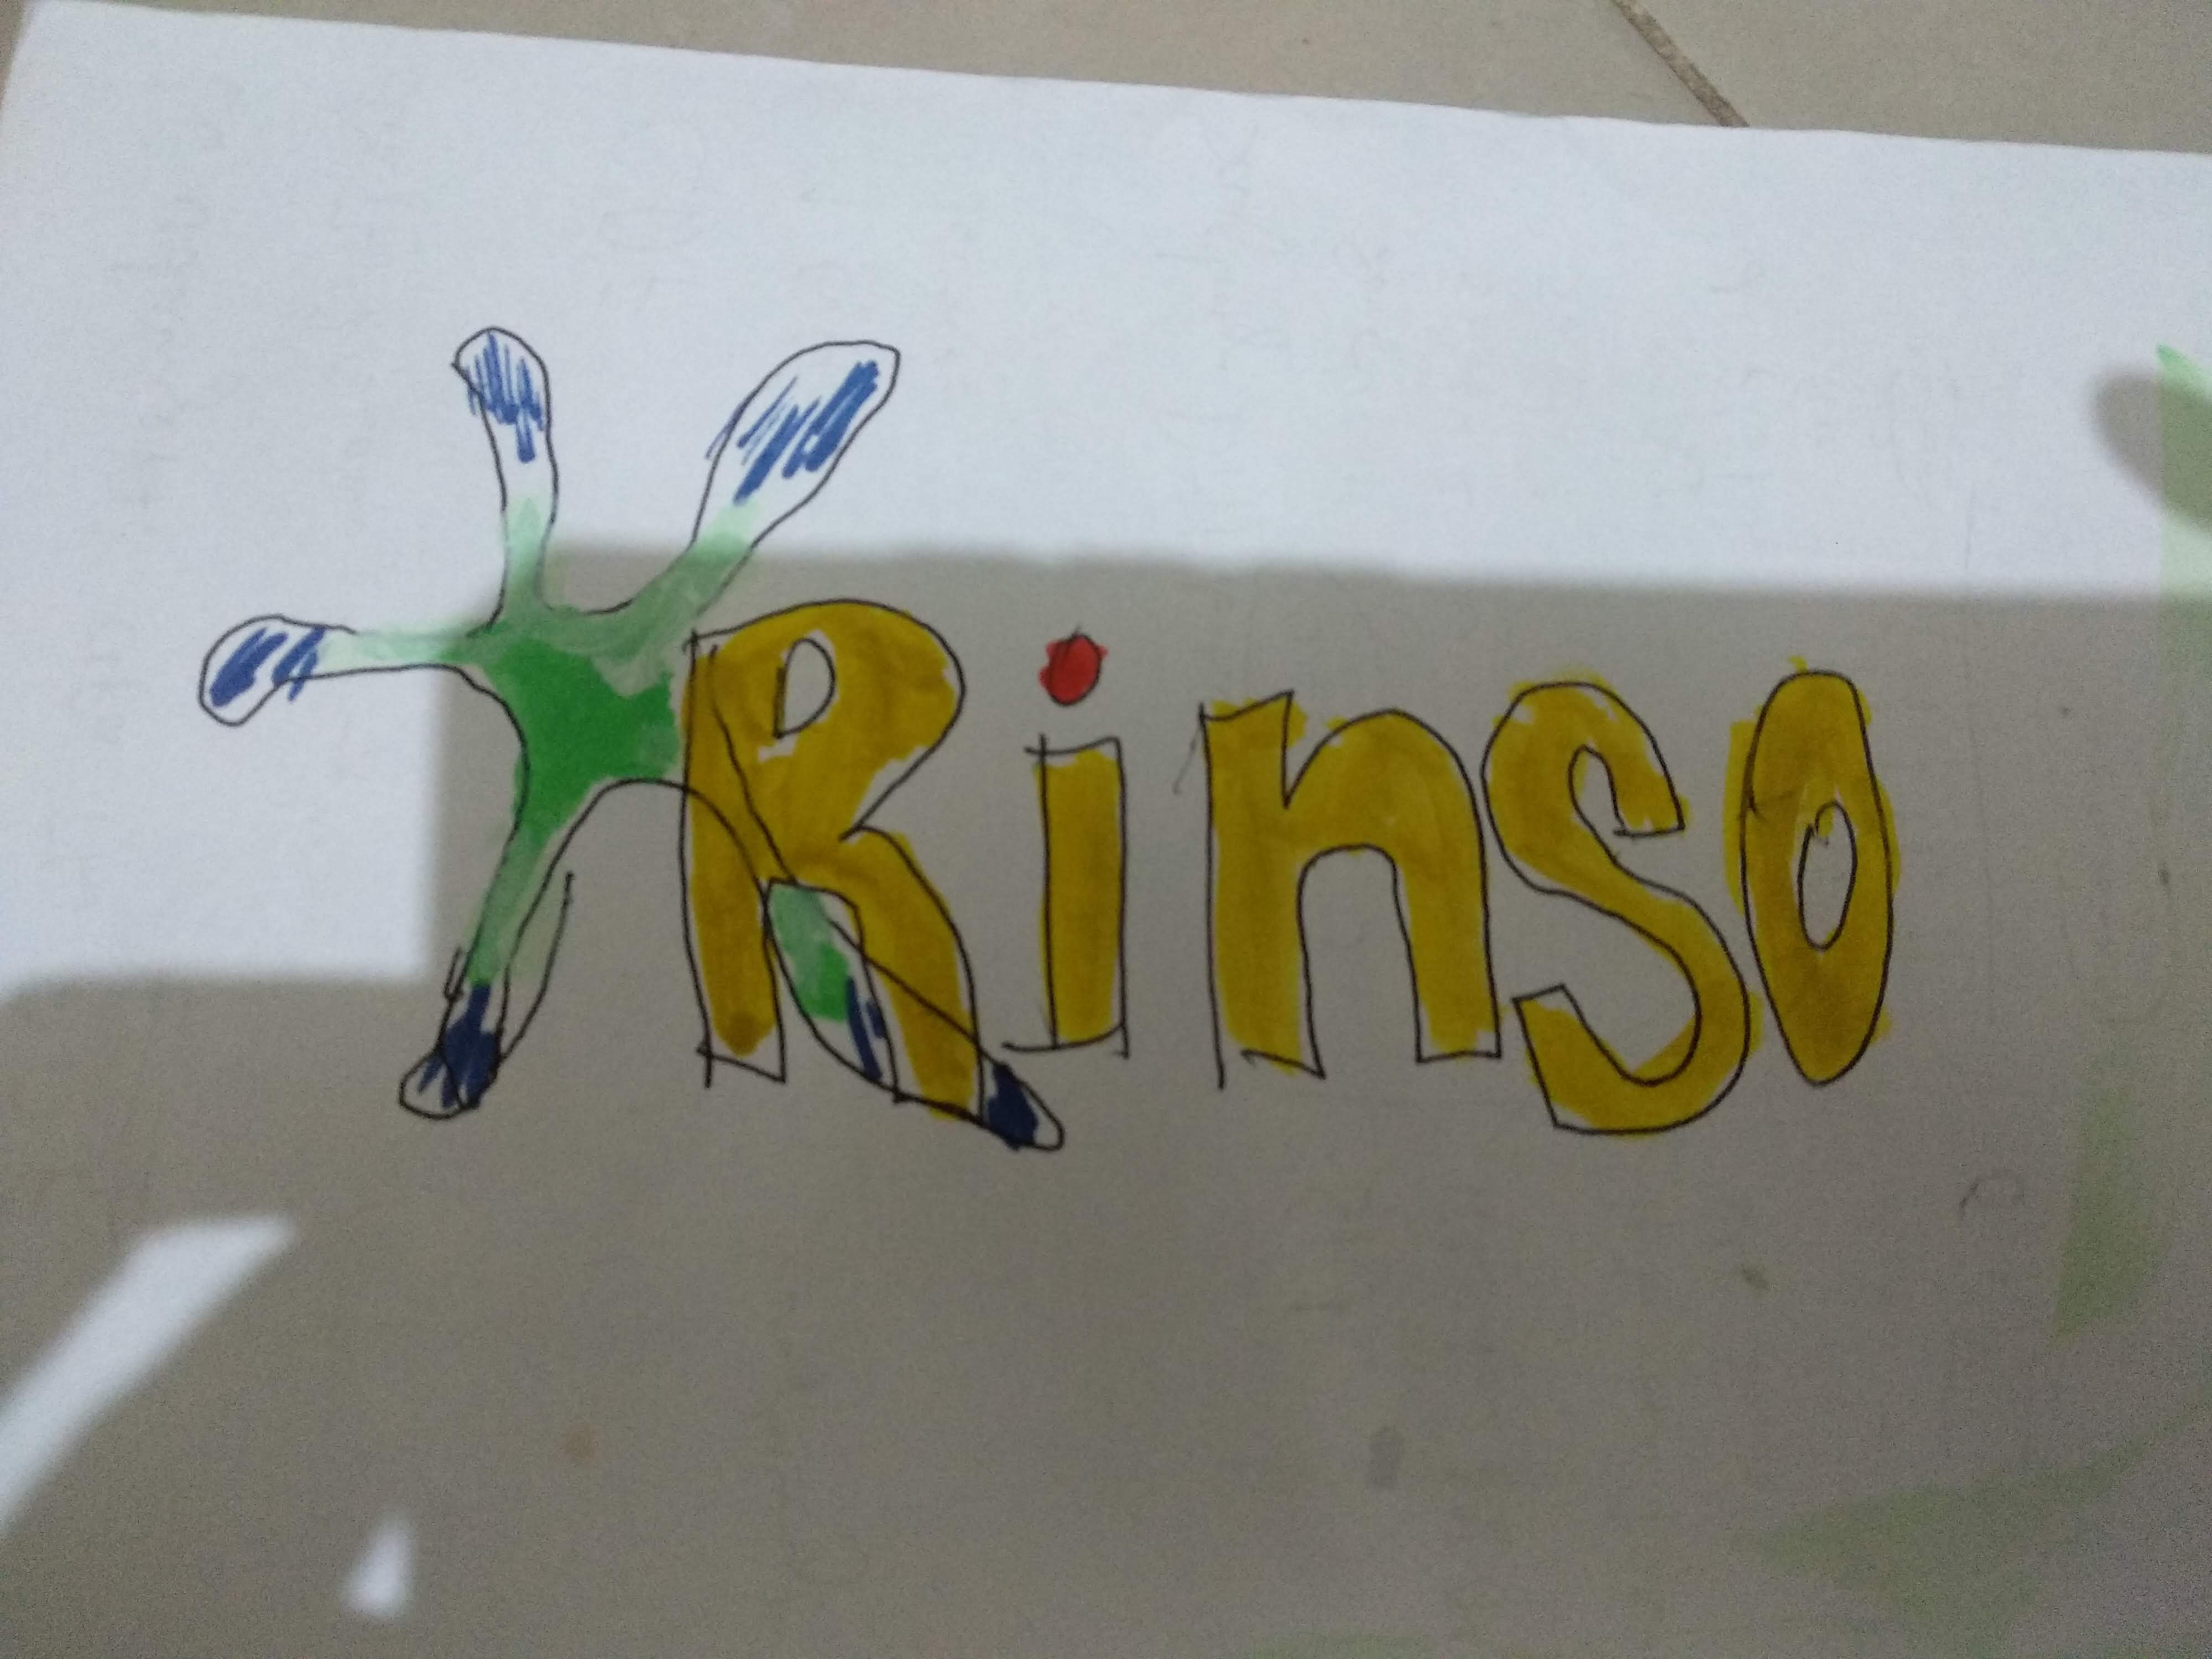

In [ ]:
PIL.Image.open(test_image)

In [ ]:
img = keras.preprocessing.image.load_img(test_image, target_size=(IMG_HEIGHT, IMG_WIDTH))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predict = final_vgg16.predict(img_array)
score = tf.nn.softmax(predict[0])
# class_names
print(f"Prediksi adalah {class_names[np.argmax(score)]} dengan persentase {np.max(score) * 100} %")

Prediksi adalah deterjenattackjpg dengan persentase 81.63687586784363 %


In [ ]:
img = keras.preprocessing.image.load_img(test_image, target_size=(IMG_HEIGHT, IMG_WIDTH))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predict = final_resnet.predict(img_array)
score = tf.nn.softmax(predict[0])
# class_names
print(f"Prediksi adalah {class_names[np.argmax(score)]} dengan persentase {np.max(score) * 100} %")

Prediksi adalah deterjenrinsojpg dengan persentase 99.84837174415588 %


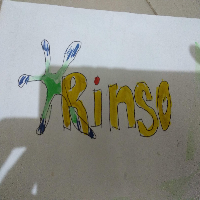

In [ ]:
img